In [0]:
import importlib
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import re

import pandas as pd
import os.path
import cPickle 
#import numpy as np
import keras.utils
import time
!pip install Keras
from keras.layers import Concatenate
from keras.callbacks import TensorBoard, CSVLogger
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Flatten,LSTM,Conv1D,GlobalMaxPool1D,Dropout,Bidirectional
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
from nltk.corpus import stopwords
import operator
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger
from tensorflow.keras.utils import plot_model
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

# Evaluation metrics
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, classification_report, log_loss, auc, roc_auc_score, roc_curve, f1_score, precision_recall_curve, recall_score, precision_score

import numpy as np
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


# New Section

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
!python -m spacy download en
nlp = spacy.load('en')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python2.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python2.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
!pip install pydot==1.2.3

In [0]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [0]:
train_data = pd.read_csv('/drive/My Drive/Colab Notebooks/Liar_new/train.csv', sep="\t")

val_data = pd.read_csv('/drive/My Drive/Colab Notebooks/Liar_new/valid.csv', sep="\t")

test_data = pd.read_csv('/drive/My Drive/Colab Notebooks/Liar_new/test.csv', sep="\t")

In [0]:
print (train_data.shape, val_data.shape, test_data.shape)
print (train_data.label.unique())
train_data.head()

((10240, 14), (1284, 14), (1267, 14))
['FALSE' 'half-true' 'mostly-true' 'TRUE' 'barely-true' 'pants-fire']


,id,label,statement,subject,speaker,job,state,party,barely-true,FALSE,half-true,mostly-true,pants-fire,venue
0,2635.json,FALSE,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,FALSE,Health care reform legislation is likely to mandate free sex change surgeries.,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of my term.,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [0]:
## Pre-processing using regular expression
def processStatement(statement):
    # process the statements
    #Convert to lower case
    #statement = statement.lower()
    #Convert www.* or https?://* to URL
    #statement = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',statement)
    #Convert @username to AT_USER
    #statement = re.sub(r'@([^\s]+)', r'\1', statement)
    #Remove additional white spaces
    statement = re.sub('[\s]+', ' ', statement)
    #Replace #word with word
    statement = re.sub(r'#([^\s]+)', r'\1', statement)
    #Replace '&amp;' with 'and'
    statement = re.sub(r'&amp;', r' and', statement)
    #trim
    statement = statement.strip('\'"')
    return statement
# END processStatement()

In [0]:
## Add a new column for pre-processing tweet content 
def adding_ppcontent_col(train_data):
    pptext=[]
    
    for line in train_data.content:
        text = processStatement(line)
        pptext.append(text)

    train_data['ppstatement'] = pptext
# END adding_ppcontent_col()

In [0]:

#####################
### OUTPUT LABELS ###
#####################

y_label_dict = {"pants-fire" : 0, "FALSE" : 1, "barely-true" : 2, "half-true" : 3, "mostly-true" : 4, "TRUE" : 5}
print (y_label_dict)

train_data['output'] = train_data['label'].apply(lambda x: y_label_dict[x])
val_data['output'] = val_data['label'].apply(lambda x: y_label_dict[x])
test_data['output'] = test_data['label'].apply(lambda x: y_label_dict[x])
num_classes = 6

{'FALSE': 1, 'half-true': 3, 'mostly-true': 4, 'pants-fire': 0, 'TRUE': 5, 'barely-true': 2}


In [0]:
#####################
###   SPEAKERS    ###
#####################

#frequent_speakers = train_data['speaker'].value_counts()[:20].reset_index().to_dict()['index']
#frequent_speakers = dict((v,k) for k,v in frequent_speakers.iteritems())
frequent_speakers = {'barack-obama' : 0, 'donald-trump' : 1, 'hillary-clinton' : 2, 
                     'mitt-romney' : 3, 'scott-walker' : 4, 'john-mccain' : 5, 
                     'rick-perry' : 6, 'chain-email' : 7, 'marco-rubio' : 8, 'viral-image':13,
                     'rick-scott' : 9, 'ted-cruz' : 10, 'bernie-s' : 11, 'newt-gingrich':16,
                     'chris-christie' : 12, 'facebook-posts' : 13,'blog-posting':13, 
                     'charlie-crist' : 14, 'congressional' : 15, 'republican' : 15, 
                     'national-committe' : 15, 'democratic':15}

print (frequent_speakers)

def get_speaker_id(speaker):
  if isinstance(speaker, str):
    matched = [sp for sp in frequent_speakers if sp in speaker.lower() ]
    if len(matched)>0:
      return frequent_speakers[matched[0]]
    else:
      return len(set(frequent_speakers.values())) 
  else:
    return len(set(frequent_speakers.values())) 
  

train_data['speaker_id'] = train_data['speaker'].apply(get_speaker_id)
val_data['speaker_id'] = val_data['speaker'].apply(get_speaker_id)
test_data['speaker_id'] = test_data['speaker'].apply(get_speaker_id)

print (len(set(frequent_speakers.values()))) 

train_data['speaker_id'].value_counts()

{'chain-email': 7, 'hillary-clinton': 2, 'john-mccain': 5, 'scott-walker': 4, 'rick-scott': 9, 'ted-cruz': 10, 'marco-rubio': 8, 'mitt-romney': 3, 'facebook-posts': 13, 'barack-obama': 0, 'donald-trump': 1, 'congressional': 15, 'newt-gingrich': 16, 'rick-perry': 6, 'blog-posting': 13, 'republican': 15, 'national-committe': 15, 'viral-image': 13, 'bernie-s': 11, 'chris-christie': 12, 'charlie-crist': 14, 'democratic': 15}
17


17    7348
0     488 
15    347 
1     275 
2     239 
3     176 
13    156 
4     149 
5     148 
6     142 
7     142 
8     117 
9     115 
10    93  
11    88  
12    78  
14    70  
16    69  
Name: speaker_id, dtype: int64

In [0]:
#####################
###   JOB TITLE   ###
#####################

#frequent_jobs = train_data['job'].str.lower().value_counts()[:20].reset_index().to_dict()['index']
#frequent_jobs = dict((v,k) for k,v in frequent_jobs.iteritems())
frequent_jobs = { 'senator' : 0, 'president' : 1, 'governor' : 2, 
                 'u.s. representative' : 3, 'attorney' : 4, 'congressman' : 5, 
                 'congresswoman' : 5, 'social media posting' : 6, 'lawyer' : 4, 
                 'businessman' : 6,  'radio host' : 8, 'host':8,
                  'mayor' : 7, 'assembly' : 9,'representative' : 3, 
                 'senate' : 9,'state representative' : 10,'milwaukee county executive' : 11,
                 'u.s. house of representatives' : 3,'house representative' : 3,
                 'house of representatives' : 3,'house member':3}


print (frequent_jobs)

def get_job_id(job):
  if isinstance(job, str):
    matched = [jb for jb in frequent_jobs if jb in job.lower() ]
    if len(matched)>0:
      return frequent_jobs[matched[0]]
    else:
      return len(set(frequent_jobs.values()))
  else:
    return len(set(frequent_jobs.values()))
  

train_data['job_id'] = train_data['job'].apply(get_job_id)
val_data['job_id'] = val_data['job'].apply(get_job_id)
test_data['job_id'] = test_data['job'].apply(get_job_id)

print (len(set(frequent_jobs.values())))

train_data['job_id'].value_counts()

{'u.s. representative': 3, 'senate': 9, 'radio host': 8, 'attorney': 4, 'lawyer': 4, 'senator': 0, 'mayor': 7, 'state representative': 10, 'house representative': 3, 'house of representatives': 3, 'social media posting': 6, 'assembly': 9, 'u.s. house of representatives': 3, 'host': 8, 'representative': 3, 'house member': 3, 'businessman': 6, 'president': 1, 'congresswoman': 5, 'milwaukee county executive': 11, 'governor': 2, 'congressman': 5}
12


12    4597
1     1205
0     1201
2     892 
3     722 
8     279 
9     260 
5     223 
4     223 
10    198 
7     167 
11    149 
6     124 
Name: job_id, dtype: int64

In [0]:
#####################
###     PARTY     ###
#####################
frequent_parties = train_data['party'].str.lower().value_counts()[:5].reset_index().to_dict()['index']
frequent_parties = dict((v,k) for k,v in frequent_parties.iteritems())
print frequent_parties
#frequent_parties['columnist']=frequent_parties['journalist']
#frequent_parties['talk-show-host']=frequent_parties['journalist']
def get_party_id(party):
  if isinstance(party, str):
    matched = [pt for pt in frequent_parties if pt in party.lower() ]
    if len(matched)>0:
      return frequent_parties[matched[0]]
    else:
      return len(set(frequent_parties.values())) 
  else:
    return len(set(frequent_parties.values())) 
  

train_data['party_id'] = train_data['party'].apply(get_party_id)
val_data['party_id'] = val_data['party'].apply(get_party_id)
test_data['party_id'] = test_data['party'].apply(get_party_id)

print len(set(frequent_parties.values())) 

train_data['party_id'].value_counts()

{'organization': 3, 'none': 2, 'republican': 0, 'democrat': 1, 'independent': 4}
5


0    4497
1    3337
2    1744
5    296 
3    219 
4    147 
Name: party_id, dtype: int64

In [0]:
train_data.loc[train_data['party_id']==9]['party'].value_counts()[:90]

Series([], Name: party, dtype: int64)

In [0]:
#####################
###     STATE     ###
#####################
#states_50 = ['Alabama','Alaska','Arizona','Arkansas','California',
#                   'Colorado', 'Connecticut','Delaware','Florida', 'Georgia',
#                   'Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas',
#                   'Kentucky','Louisiana','Maine','Maryland','Massachusetts',
#                   'Michigan','Minnesota','Mississippi', 'Missouri','Montana',
#                   'Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
#                   'New York','North Carolina','North Dakota','Ohio','Oklahoma',
#                   'Oregon','Pennsylvania','Rhode Island','South Carolina',
#                   'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia',
#                   'Washington','West Virginia','Wisconsin','Wyoming']

# frequent_states = dict((v.lower(),k) for k,v in enumerate(states_50))

other_states = ['wyoming', 'colorado', 'hawaii', 'tennessee', 'nevada', 'maine',
                'north dakota', 'mississippi', 'south dakota', 'oklahoma', 
                'delaware', 'minnesota', 'north carolina', 'arkansas', 'indiana', 
                'maryland', 'louisiana', 'idaho', 'iowa', 'west virginia', 
                'michigan', 'kansas', 'utah', 'connecticut', 'montana', 'vermont', 
                'pennsylvania', 'alaska', 'kentucky', 'nebraska', 'new hampshire', 
                'missouri', 'south carolina', 'alabama', 'new mexico']


frequent_states = {'texas': 1, 'florida': 2, 'wisconsin': 3, 'new york': 4, 
                    'illinois': 5, 'ohio': 6, 'georgia': 7, 'virginia': 8, 
                   'rhode island': 9, 'oregon': 10, 'new jersey': 11, 
                   'massachusetts': 12, 'arizona': 13, 'california': 14, 
                   'washington': 15}
for state in other_states:
  frequent_states[state]=0

print (frequent_states)

def get_state_id(state):
    if isinstance(state, str):
        if state.lower().rstrip() in frequent_states:
            return frequent_states[state.lower().rstrip()]
        else:
            if 'washington' in state.lower():
                return frequent_states['washington']
            else:
                return len(set(frequent_states.values()))
    else:
        return len(set(frequent_states.values()))


train_data['state_id'] = train_data['state'].apply(get_state_id)
val_data['state_id'] = val_data['state'].apply(get_state_id)
test_data['state_id'] = test_data['state'].apply(get_state_id)

print (len(set(frequent_states.values())))

train_data['state_id'].value_counts()

{'colorado': 0, 'washington': 15, 'rhode island': 9, 'tennessee': 0, 'nevada': 0, 'maine': 0, 'mississippi': 0, 'south dakota': 0, 'new jersey': 11, 'wyoming': 0, 'minnesota': 0, 'north carolina': 0, 'new york': 4, 'indiana': 0, 'maryland': 0, 'louisiana': 0, 'texas': 1, 'iowa': 0, 'michigan': 0, 'utah': 0, 'virginia': 8, 'oregon': 10, 'connecticut': 0, 'georgia': 7, 'hawaii': 0, 'kentucky': 0, 'nebraska': 0, 'new hampshire': 0, 'missouri': 0, 'south carolina': 0, 'ohio': 6, 'north dakota': 0, 'oklahoma': 0, 'delaware': 0, 'illinois': 5, 'arkansas': 0, 'idaho': 0, 'arizona': 13, 'wisconsin': 3, 'kansas': 0, 'montana': 0, 'california': 14, 'massachusetts': 12, 'vermont': 0, 'pennsylvania': 0, 'florida': 2, 'alaska': 0, 'west virginia': 0, 'alabama': 0, 'new mexico': 0}
16


16    2238
0     1211
1     1009
2     1003
3     714 
4     659 
5     558 
6     448 
7     433 
8     408 
9     371 
10    242 
11    241 
12    212 
13    182 
14    163 
15    148 
Name: state_id, dtype: int64

In [0]:
#####################
###    SUBJECT    ###
#####################
frequent_subjects = train_data['subject'].str.lower().value_counts()[:25]

# health-care               381
# taxes                     308
# immigration               253
# elections                 252
# education                 237
# candidates-biography      190
# economy                   137
# guns                      130
# economy,jobs              125
# federal-budget            121
# jobs                       98
# energy                     94
# abortion                   92
# foreign-policy             85
# state-budget               75
# education,state-budget     69
# transportation             64
# crime                      59
# ethics                     58
# iraq                       55
# campaign-finance           53
# terrorism                  53
# environment                52
# history                    45
# job-accomplishments        45

frequent_subjects = {'health': 0, 'tax': 1, 'immigration': 2, 'election': 3, 
                     'education': 4, 'candidates-biography': 5, 'economy': 6, 
                     'gun': 7, 'job': 8, 'federal-budget': 6, 'energy': 9, 
                     'abortion': 10, 'foreign-policy': 6, 'state-budget': 6, 
                     'crime': 11, 'gays-and-lesbians' : 12, 'medicare' : 0, 
                     'terrorism' : 11, 'finance' : 6, 'criminal':11,
                     'transportation':13}

print (frequent_subjects)


def get_subject_id(subject):
  if isinstance(subject, str):
    matched = [sbj for sbj in frequent_subjects if sbj in subject.lower() ]
    if len(matched)>0:
      return frequent_subjects[matched[0]]
    else:
      return len(set(frequent_subjects.values())) 
  else:
    return len(set(frequent_subjects.values()))
  

train_data['subject_id'] = train_data['subject'].apply(get_subject_id)
val_data['subject_id'] = val_data['subject'].apply(get_subject_id)
test_data['subject_id'] = test_data['subject'].apply(get_subject_id)

print (len(set(frequent_subjects.values())))

train_data['subject_id'].value_counts()

#print (train_data.loc[train_data['subject_id']==15]['subject'].value_counts())

{'foreign-policy': 6, 'criminal': 11, 'transportation': 13, 'federal-budget': 6, 'crime': 11, 'abortion': 10, 'energy': 9, 'tax': 1, 'immigration': 2, 'candidates-biography': 5, 'gun': 7, 'job': 8, 'health': 0, 'election': 3, 'state-budget': 6, 'finance': 6, 'medicare': 0, 'terrorism': 11, 'education': 4, 'gays-and-lesbians': 12, 'economy': 6}
14


6     2143
14    1909
0     954 
1     846 
8     728 
11    660 
5     518 
3     468 
2     450 
4     395 
9     350 
13    261 
10    237 
7     235 
12    86  
Name: subject_id, dtype: int64

In [0]:
#####################
###     VENUE     ###
#####################

frequent_venues = {'news release' : 0, 'interview' : 1, 'press release' : 2, 
                   'speech' : 3, 'tv' : 4, 'tweet' : 5, 'campaign' : 6, 
                   'television' : 4, 'debate' : 7, 'news conference' : 8, 
                   'facebook' : 5, 'press conference' : 8, 'radio' : 9, 
                   'e-mail' : 10, 'email' : 10, 'mail' : 10, 'social media' : 5,
                   'twitter' : 5, 'blog':11, 'article':11,'comment':12, 'web':11}

print (frequent_venues)


def get_venue_id(venue):
  if isinstance(venue, str):
    matched = [ven for ven in frequent_venues if ven in venue.lower() ]
    if len(matched)>0:
      return frequent_venues[matched[0]]
    else:
      return len(set(frequent_venues.values())) 
  else:
    return len(set(frequent_venues.values()))
  

train_data['venue_id'] = train_data['venue'].apply(get_venue_id)
val_data['venue_id'] = val_data['venue'].apply(get_venue_id)
test_data['venue_id'] = test_data['venue'].apply(get_venue_id)

print (len(set(frequent_venues.values())))

train_data['venue_id'].value_counts()

#print (train_data.loc[train_data['venue_id']==13]['venue'].value_counts())

{'comment': 12, 'campaign': 6, 'twitter': 5, 'radio': 9, 'debate': 7, 'social media': 5, 'tv': 4, 'tweet': 5, 'blog': 11, 'e-mail': 10, 'speech': 3, 'interview': 1, 'mail': 10, 'email': 10, 'web': 11, 'news conference': 8, 'press conference': 8, 'facebook': 5, 'news release': 0, 'press release': 2, 'article': 11, 'television': 4}
13


13    2695
1     1419
3     1010
6     803 
7     729 
4     628 
11    536 
5     464 
12    402 
10    353 
2     331 
9     317 
0     306 
8     247 
Name: venue_id, dtype: int64

In [0]:
train_data.head()

,id,label,statement,subject,speaker,job,state,party,barely-true,FALSE,half-true,mostly-true,pants-fire,venue,output,speaker_id,job_id,party_id,state_id,subject_id,venue_id
0,2635.json,FALSE,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,1,17,10,0,1,10,10
1,10540.json,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,3,17,12,1,8,9,3
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,4,0,1,1,5,6,13
3,1123.json,FALSE,Health care reform legislation is likely to mandate free sex change surgeries.,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,1,13,12,2,16,0,0
4,9028.json,half-true,The economic turnaround started at the end of my term.,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,3,14,12,1,2,8,1


In [0]:
#####################
###   STATEMENT   ###
#####################

def load_statement_vocab_dict(train_data):
  vocabulary_dict = {}
  if not os.path.exists('vocabulary.p'):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_data['statement'])
    vocabulary_dict = tokenizer.word_index
    print (len(vocabulary_dict))
    cPickle.dump(vocabulary_dict, open( "vocabulary.p", "wb" ))
    print ('Created Vocabulary Dictionary...')
    print ('Saved Vocabulary Dictionary...')
  else:
    print ('Loading Vocabulary Dictionary...')
    vocabulary_dict = cPickle.load(open("vocabulary.p", "rb" ))
  return vocabulary_dict


def preprocess_statement(statement):
  statement = [w for w in statement.split(' ') if w not in stopwords.words('english')]
  statement = ' '.join(statement)
  text = text_to_word_sequence(statement)
  val = [0] * 10
  val = [vocabulary_dict[t] for t in text if t in vocabulary_dict] 
  return val


vocabulary_dict = load_statement_vocab_dict(train_data)
train_data['word_id'] = train_data['statement'].apply(preprocess_statement)
val_data['word_id'] = val_data['statement'].apply(preprocess_statement)
test_data['word_id'] = test_data['statement'].apply(preprocess_statement)

Loading Vocabulary Dictionary...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [0]:
##########################################
###   Part of speech (POS) TAGS    ###
##########################################

pos_tags = {'ADJ': 'adjective', 'ADP': 'adposition', 'ADV': 'adverb', 
            'AUX': 'auxiliary verb', 'CONJ': 'coordinating conjunction', 
            'DET': 'determiner', 'INTJ': 'interjection', 'NOUN': 'noun', 
            'NUM': 'numeral', 'PART': 'particle', 'PRON': 'pronoun', 
            'PROPN': 'proper noun', 'PUNCT': 'punctuation', 'X': 'other', 
            'SCONJ': 'subord conjunction', 'SYM': 'symbol', 'VERB': 'verb'}

#pos_dict = {'ADJ' : 0, 'ADP' : 1, 'ADV' : 2, 'AUX' : 3, 'CONJ' : 4, 'DET' : 5, 
#            'INTJ' : 6, 'NOUN' : 7, 'NUM' : 8, 'PART' : 9, 'PRON' : 10, 'X' : 16,
#            'PROPN' : 11, 'PUNCT' : 12, 'SCONJ' : 13, 'SYM' : 14, 'VERB' : 15}

pos_dict = {'NOUN' : 0, 'VERB' : 1, 'ADP' : 2, 'PROPN' : 3, 'PUNCT' : 4, 
            'DET' : 5, 'ADJ' : 6, 'NUM' : 7, 'ADV' : 8, 'PRON' : 9, 'X' : 9, 
            'PART' : 9, 'SYM' : 9, 'INTJ' : 9 }

dep_dict = {'ACL' : 0, 'ACOMP' : 1, 'ADVCL' : 2, 'ADVMOD' : 3, 'AGENT' : 4, 
            'AMOD' : 5, 'APPOS' : 6, 'ATTR' : 7, 'AUX' : 8, 'AUXPASS' : 9, 
            'CASE' : 10, 'CC' : 11, 'CCOMP' : 12, 'COMPOUND' : 13, 'CONJ' : 14, 
            'CSUBJ' : 15, 'CSUBJPASS' : 16, 'DATIVE' : 17, 'DEP' : 18, 
            'DET' : 19, 'DOBJ' : 20, 'EXPL' : 21, 'INTJ' : 22, 'MARK' : 23, 
            'META' : 24, 'NEG' : 25, 'NOUNMOD' : 26, 'NPMOD' : 27, 'NSUBJ' : 28, 
            'NSUBJPASS' : 29, 'NUMMOD' : 30, 'OPRD' : 31, 'PARATAXIS' : 32, 
            'PCOMP' : 33, 'POBJ' : 34, 'POSS' : 35, 'PRECONJ' : 36, 'PREDET' : 37, 
            'PREP' : 38, 'PRT' : 39, 'PUNCT' : 40, 'QUANTMOD' : 41, 
            'RELCL' : 42, 'ROOT' : 43, 'XCOMP' : 44}

def get_pos(statement):
  doc = nlp(statement.decode('utf-8', 'ignore'))
  taglist = []
  deplist = []
  for token in doc:
    taglist.append(pos_dict.get(token.pos_,max(pos_dict.values())))
    #deplist.append(token.dep_)
  return taglist
train_data['pos_id'] = train_data['statement'].apply(get_pos)
val_data['pos_id'] = val_data['statement'].apply(get_pos)
test_data['pos_id'] = test_data['statement'].apply(get_pos)

In [0]:
##########################################
###   Dependency Parse tag   ###
##########################################

dep_dict = {'ACL' : 0, 'ACOMP' : 1, 'ADVCL' : 2, 'ADVMOD' : 3, 'AGENT' : 4, 
            'AMOD' : 5, 'APPOS' : 6, 'ATTR' : 7, 'AUX' : 8, 'AUXPASS' : 9, 
            'CASE' : 10, 'CC' : 11, 'CCOMP' : 12, 'COMPOUND' : 13, 'CONJ' : 14, 
            'CSUBJ' : 15, 'CSUBJPASS' : 16, 'DATIVE' : 17, 'DEP' : 18, 
            'DET' : 19, 'DOBJ' : 20, 'EXPL' : 21, 'INTJ' : 22, 'MARK' : 23, 
            'META' : 24, 'NEG' : 25, 'NOUNMOD' : 26, 'NPMOD' : 27, 'NSUBJ' : 28, 
            'NSUBJPASS' : 29, 'NUMMOD' : 30, 'OPRD' : 31, 'PARATAXIS' : 32, 
            'PCOMP' : 33, 'POBJ' : 34, 'POSS' : 35, 'PRECONJ' : 36, 'PREDET' : 37, 
            'PREP' : 38, 'PRT' : 39, 'PUNCT' : 40, 'QUANTMOD' : 41, 
            'RELCL' : 42, 'ROOT' : 43, 'XCOMP' : 44}


dep_dict = {'punct' : 0, 'prep' : 1, 'pobj' : 2, 'compound' : 3, 'det' : 4, 
            'nsubj' : 5, 'ROOT' : 6, 'amod' : 7, 'dobj' : 8, 'aux' : 9, 
            'advmod' : 10, 'nummod' : 10, 'ccomp' : 10, 'conj' : 10, 'cc' : 10, 
            'advcl' : 10, 'poss' : 10, 'mark' : 10, 'quantmod' : 10, 'relcl' : 10, 
            'attr' : 10, 'xcomp' : 10, 'npadvmod' : 10, 'nmod' : 10, 'auxpass' : 10, 
            'acl' : 10, 'nsubjpass' : 10, 'pcomp' : 10, 'acomp' : 10, 'neg' : 10, 
            'appos' : 10, 'prt' : 10, '' : 10, 'expl' : 10, 'dative' : 10, 
            'agent' : 10, 'case' : 10, 'oprd' : 10, 'csubj' : 10, 'dep' : 10, 
            'intj' : 10, 'predet' : 10, 'parataxis' : 10, 'preconj' : 10, 
            'meta' : 10, 'csubjpass' : 10}


def get_dep_parse(statement):
  doc = nlp(statement.decode('utf-8', 'ignore'))
  deplist = []
  for token in doc:
    deplist.append(dep_dict.get(token.dep_, max(dep_dict.values())))
  return deplist


train_data['dep_id'] = train_data['statement'].apply(get_dep_parse)
val_data['dep_id'] = val_data['statement'].apply(get_dep_parse)
test_data['dep_id'] = test_data['statement'].apply(get_dep_parse)

In [0]:
train_data.head()

,id,label,statement,subject,speaker,job,state,party,barely-true,FALSE,half-true,mostly-true,pants-fire,venue,output,speaker_id,job_id,party_id,state_id,subject_id,venue_id,word_id,pos_id,dep_id
0,2635.json,FALSE,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,1,17,10,0,1,10,10,"[7, 6968, 1141, 520, 621, 385, 444, 5119, 585, 1601]","[1, 5, 3, 3, 6, 0, 1, 6, 4, 0, 0, 2, 0, 4]","[6, 4, 3, 10, 7, 5, 10, 7, 0, 3, 8, 1, 2, 0]"
1,10540.json,half-true,When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,3,17,12,1,8,9,3,"[63, 2091, 964, 866, 23, 602, 1142, 315, 180, 602, 1959, 34, 310, 560, 1365, 177]","[8, 1, 5, 0, 2, 0, 0, 4, 9, 1, 8, 6, 0, 1, 9, 5, 1, 9, 1, 2, 4, 3, 3, 3, 4, 3, 0, 4]","[10, 6, 4, 5, 1, 3, 2, 0, 5, 6, 10, 7, 5, 10, 10, 5, 10, 9, 10, 1, 0, 3, 3, 10, 0, 3, 6, 0]"
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran.""",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,4,0,1,1,5,6,13,"[127, 101, 3546, 191, 254, 20, 329, 343, 310, 166, 1093, 3547, 416]","[3, 3, 1, 2, 3, 3, 4, 2, 1, 9, 1, 3, 3, 5, 0, 2, 5, 0, 2, 3, 4, 4]","[3, 5, 6, 1, 3, 2, 0, 1, 10, 9, 10, 3, 10, 4, 8, 1, 4, 2, 1, 2, 0, 6]"
3,1123.json,FALSE,Health care reform legislation is likely to mandate free sex change surgeries.,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,1,13,12,2,16,0,0,"[32, 43, 266, 298, 666, 667, 404, 467, 417, 4148]","[0, 0, 0, 0, 1, 6, 9, 1, 6, 0, 0, 0, 4]","[3, 3, 3, 5, 6, 10, 9, 10, 7, 3, 3, 8, 0]"
4,9028.json,half-true,The economic turnaround started at the end of my term.,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,3,14,12,1,2,8,1,"[1, 325, 4149, 602, 408, 505]","[5, 6, 0, 1, 2, 5, 0, 2, 5, 0, 4]","[4, 7, 5, 6, 1, 4, 2, 1, 10, 2, 0]"


In [0]:
#####################
###  EMBEDDINGS   ###
#####################

embeddings = {}
with open("/drive/My Drive/Colab Notebooks/Liar_new/glove.6B.100d.txt") as file_object:
  for line in file_object:
    word_embed = line.split()
    word = word_embed[0]
    embed = np.array(word_embed[1:], dtype="float32")
    embeddings[word.lower()]= embed

EMBED_DIM = 100
print len(embeddings), " : Word Embeddings Found"
print len(embeddings[word]), " : Embedding Dimension"


num_words = len(vocabulary_dict) + 1
embedding_matrix = np.zeros((num_words, EMBED_DIM))
for word, i in vocabulary_dict.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embeddings_index = None



pos_embeddings = np.identity(max(pos_dict.values()), dtype=int)
dep_embeddings = np.identity(max(dep_dict.values()), dtype=int)

400000  : Word Embeddings Found
100  : Embedding Dimension


In [0]:
#####################
###  HYPERPARAMS  ###
#####################
vocab_length = len(vocabulary_dict.keys())
hidden_size = EMBED_DIM #Has to be same as EMBED_DIM
lstm_size = 100
num_steps = 15
num_epochs = 10
batch_size = 300

#Hyperparams for CNN
kernel_sizes = [3,3,3]
filter_size = 128

#Meta data related hyper params
num_party = len(train_data.party_id.unique())
num_state = len(train_data.state_id.unique())
num_venue = len(train_data.venue_id.unique())
num_job = len(train_data.job_id.unique())
num_sub = len(train_data.subject_id.unique())
num_speaker = len(train_data.speaker_id.unique())
print (num_party)
print (num_state)
print (num_venue)
print (num_job)
print (num_sub)
print (num_speaker)
print (train_data.columns)

6
17
14
13
15
18
Index([u'id', u'label', u'statement', u'subject', u'speaker', u'job', u'state',
       u'party', u'barely-true', u'FALSE', u'half-true', u'mostly-true',
       u'pants-fire', u'venue', u'output', u'speaker_id', u'job_id',
       u'party_id', u'state_id', u'subject_id', u'venue_id', u'word_id',
       u'pos_id', u'dep_id'],
      dtype='object')


In [0]:
#####################
###   DATA PREP   ###
#####################

X_train = train_data['word_id']
X_val = val_data['word_id']
X_test = test_data['word_id']

Y_val = val_data['output']
Y_val = keras.utils.to_categorical(Y_val, num_classes=6)

X_train = sequence.pad_sequences(X_train, maxlen=num_steps, padding='post',truncating='post')
X_val = sequence.pad_sequences(X_val, maxlen=num_steps, padding='post',truncating='post')
X_test = sequence.pad_sequences(X_test, maxlen=num_steps, padding='post',truncating='post')

X_train_pos = train_data['pos_id']
X_val_pos = val_data['pos_id']
X_test_pos = test_data['pos_id']

X_train_pos = sequence.pad_sequences(X_train_pos, maxlen=num_steps, padding='post',truncating='post')
X_val_pos = sequence.pad_sequences(X_val_pos, maxlen=num_steps, padding='post',truncating='post')
X_test_pos = sequence.pad_sequences(X_test_pos, maxlen=num_steps, padding='post',truncating='post')


X_train_dep = train_data['dep_id']
X_val_dep = val_data['dep_id']
X_test_dep = test_data['dep_id']

X_train_dep = sequence.pad_sequences(X_train_dep, maxlen=num_steps, padding='post',truncating='post')
X_val_dep = sequence.pad_sequences(X_val_dep, maxlen=num_steps, padding='post',truncating='post')
X_test_dep = sequence.pad_sequences(X_test_dep, maxlen=num_steps, padding='post',truncating='post')


#Meta data preparation
party_train = keras.utils.to_categorical(train_data['party_id'], num_classes=num_party)
state_train = keras.utils.to_categorical(train_data['state_id'], num_classes=num_state)
venue_train = keras.utils.to_categorical(train_data['venue_id'], num_classes=num_venue)
job_train = keras.utils.to_categorical(train_data['job_id'], num_classes=num_job)
subject_train = keras.utils.to_categorical(train_data['subject_id'], num_classes=num_sub)
speaker_train = keras.utils.to_categorical(train_data['speaker_id'], num_classes=num_speaker)

#X_train_meta = party_train
X_train_meta = np.hstack((party_train, state_train, venue_train, job_train, subject_train, speaker_train))

party_val = keras.utils.to_categorical(val_data['party_id'], num_classes=num_party)
state_val = keras.utils.to_categorical(val_data['state_id'], num_classes=num_state)
venue_val = keras.utils.to_categorical(val_data['venue_id'], num_classes=num_venue)
job_val = keras.utils.to_categorical(val_data['job_id'], num_classes=num_job)
subject_val = keras.utils.to_categorical(val_data['subject_id'], num_classes=num_sub)
speaker_val = keras.utils.to_categorical(val_data['speaker_id'], num_classes=num_speaker)

#X_val_meta = party_val
X_val_meta = np.hstack((party_val, state_val, venue_val, job_val, subject_val, speaker_val))

party_test = keras.utils.to_categorical(test_data['party_id'], num_classes=num_party)
state_test = keras.utils.to_categorical(test_data['state_id'], num_classes=num_state)
venue_test = keras.utils.to_categorical(test_data['venue_id'], num_classes=num_venue)
job_test = keras.utils.to_categorical(test_data['job_id'], num_classes=num_job)
subject_test = keras.utils.to_categorical(test_data['subject_id'], num_classes=num_sub)
speaker_test = keras.utils.to_categorical(test_data['speaker_id'], num_classes=num_speaker)

#X_test_meta = party_test
X_test_meta = np.hstack((party_test, state_test, venue_test, job_test, subject_test, speaker_test))

In [0]:
print X_train_meta.shape, X_val_meta.shape, X_test_meta.shape
print X_train.shape, X_val.shape, X_test.shape
print X_train_pos.shape, X_val_pos.shape, X_test_pos.shape
print X_train_dep.shape, X_val_dep.shape, X_test_dep.shape

print X_train_dep, X_val_dep, X_test_dep

(10240, 83) (1284, 83) (1267, 83)
(10240, 15) (1284, 15) (1267, 15)
(10240, 15) (1284, 15) (1267, 15)
(10240, 15) (1284, 15) (1267, 15)
[[ 6  4  3 ...  2  0  0]
 [10  6  4 ...  5 10 10]
 [ 3  5  6 ... 10  4  8]
 ...
 [ 6  4  5 ... 10  0  9]
 [ 6 10  4 ...  0  0  0]
 [ 4  5  1 ...  8  8 10]] [[ 5  6  7 ...  0  0  0]
 [10 10 10 ...  3  8  0]
 [ 6 10  5 ... 10  1  4]
 ...
 [ 3  5 10 ...  3  2  0]
 [ 4  7  5 ... 10  3  8]
 [ 4  5  6 ...  4  3  2]] [[10  4  8 ...  0  0  0]
 [ 5  6  1 ...  0  0  0]
 [ 6  3  5 ...  0  0  0]
 ...
 [ 1  4  7 ...  7  5 10]
 [ 6  4  3 ... 10  5 10]
 [ 6  4  5 ...  0  5  9]]


In [0]:
def train(model, name, use_pos=False, use_meta=False, use_dep=False):
  #sgd = optimizers.SGD(lr=0.025, clipvalue=0.3, nesterov=True)
  rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0) 
  #adagrad = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
  #adam = optimizers.Adam(lr=0.000075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(optimizer=rmsprop,loss='categorical_crossentropy',metrics=['categorical_accuracy'])
  #model.compile(optimizer=rmsprop,loss='categorical_crossentropy',metrics=['categorical_accuracy'])
  #model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['categorical_accuracy'])
  tb = TensorBoard()
  csv_logger = keras.callbacks.CSVLogger('training.log')
  filepath= name+"_weights_best.hdf5"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_categorical_accuracy', 
                                             verbose=1, save_best_only=True, mode='max')
  
  if use_pos and use_meta:
    if use_dep:
      model.fit(
        {'main_input': X_train, 'pos_input': X_train_pos, 
         'aux_input': X_train_meta, 'dep_input': X_train_dep},
        {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
        validation_data = (
            {'main_input': X_val, 'pos_input': X_val_pos, 
             'aux_input': X_val_meta, 'dep_input' : X_val_dep},
            {'main_output': Y_val}
        ), callbacks=[tb,csv_logger,checkpoint])
    else:
      model.fit(
        {'main_input': X_train, 'pos_input': X_train_pos, 'aux_input': X_train_meta},
        {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
        validation_data = (
            {'main_input': X_val, 'pos_input': X_val_pos, 'aux_input': X_val_meta},
            {'main_output': Y_val}
        ), callbacks=[tb,csv_logger,checkpoint])
  elif use_meta:
    if use_dep:
      model.fit(
        {'main_input': X_train, 'aux_input': X_train_meta,'dep_input':X_train_dep},
        {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
        validation_data = (
            {'main_input': X_val, 'aux_input': X_val_meta, 'dep_input': X_val_dep},
            {'main_output': Y_val}
        ), callbacks=[tb,csv_logger,checkpoint])
    else:
      model.fit(
        {'main_input': X_train, 'aux_input': X_train_meta},
        {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
        validation_data = (
            {'main_input': X_val, 'aux_input': X_val_meta},
            {'main_output': Y_val}
        ), callbacks=[tb,csv_logger,checkpoint])
  elif use_pos:
    if use_dep:
      model.fit(
        {'main_input': X_train, 'pos_input': X_train_pos,'dep_input':X_train_dep},
        {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
        validation_data = (
            {'main_input': X_val, 'pos_input': X_val_pos, 'dep_input':X_val_dep},
            {'main_output': Y_val}
        ), callbacks=[tb,csv_logger,checkpoint])
    else:
      model.fit(
        {'main_input': X_train, 'pos_input': X_train_pos},
        {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
        validation_data = (
            {'main_input': X_val, 'pos_input': X_val_pos},
            {'main_output': Y_val}
        ), callbacks=[tb,csv_logger,checkpoint])
  else:
    if use_dep:
      model.fit(
        {'main_input': X_train,'dep_input':X_train_dep},
        {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
        validation_data = (
            {'main_input': X_val, 'dep_input':X_val_dep},
            {'main_output': Y_val}
        ), callbacks=[tb,csv_logger,checkpoint])
    else:
      model.fit(
        {'main_input': X_train},
        {'main_output': Y_train}, epochs = num_epochs, batch_size = batch_size,
        validation_data = (
            {'main_input': X_val},
            {'main_output': Y_val}
        ), callbacks=[tb,csv_logger,checkpoint])
    
  
  
def evaluate(name, use_pos=False, use_meta=False, use_dep=False):
  model1 = load_model(name+'_weights_best.hdf5')
  if use_pos and use_meta:
    if use_dep:
      preds = model1.predict([X_test,X_test_pos, X_test_dep, X_test_meta], batch_size=batch_size, verbose=1)
    else:
      preds = model1.predict([X_test,X_test_pos, X_test_meta], batch_size=batch_size, verbose=1)
  elif use_meta:
    if use_dep:
      preds = model1.predict([X_test, X_test_dep, X_test_meta], batch_size=batch_size, verbose=1)
    else:
      preds = model1.predict([X_test, X_test_meta], batch_size=batch_size, verbose=1)
  elif use_pos:
    if use_dep:
      preds = model1.predict([X_test, X_test_pos, X_test_dep], batch_size=batch_size, verbose=1)
    else:
      preds = model1.predict([X_test, X_test_pos], batch_size=batch_size, verbose=1)
  else:
    if use_dep:
      preds = model1.predict([X_test, X_test_dep], batch_size=batch_size, verbose=1)
    else:
      preds = model1.predict([X_test], batch_size=batch_size, verbose=1)
    
  false_worst = {}
  true_best = {}
  label_list = ['pants-fire','false','barely-true','half-true','mostly-true','true']

  Y_test_gt = list(test_data['output'])
  predictions = np.array([np.argmax(pred) for pred in preds])
  
  for p in range(len(preds)):
    if np.argmax(preds[p])==0:
      false_worst[p]=preds[p][0]
    elif np.argmax(preds[p])==5:
      true_best[p]=preds[p][5]
      
  print len(predictions)==len(Y_test_gt)
  correct = np.sum(predictions == Y_test_gt)
  print "Correctly Predicted : ", correct,"/",len(Y_test_gt)
  print "Accuracy : ", correct*100.0/len(Y_test_gt)
  cPickle.dump(predictions, open(name+'_predictions.p','wb'))
  return (false_worst, true_best)

In [0]:
def print_best_false_true_predicted(fw, tb):
  sorted_false = sorted(fw.items(), key=operator.itemgetter(1), reverse=True)
  sorted_true = sorted(tb.items(), key=operator.itemgetter(1), reverse=True)
  print '*****************************************************************'
  print '******************** False statements *************************'
  
  for t in sorted_false[:5]:
    print t[1]
    print test_data.loc[t[0]]
    print '============='
  print '*****************************************************************'
  print '******************** True Statements *************************'  
  for t in sorted_true[:5]:
    print t[1]
    print test_data.loc[t[0]]
    print '============='

In [0]:
#####################
###  HYPERPARAMS  ###
#####################
vocab_length = len(vocabulary_dict.keys())
hidden_size = EMBED_DIM #Has to be same as EMBED_DIM
lstm_size = 100
num_steps = 15
num_epochs = 10
batch_size = 300

#Hyperparams for CNN
kernel_sizes = [3,3,3]
filter_size = 128

#Meta data related hyper params
num_party = len(train_data.party_id.unique())
num_state = len(train_data.state_id.unique())
num_venue = len(train_data.venue_id.unique())
num_job = len(train_data.job_id.unique())
num_sub = len(train_data.subject_id.unique())
num_speaker = len(train_data.speaker_id.unique())
print num_party
print num_state
print num_venue
print num_job
print num_sub
print num_speaker
print train_data.columns

6
17
14
13
15
18
Index([u'id', u'label', u'statement', u'subject', u'speaker', u'job', u'state',
       u'party', u'barely-true', u'FALSE', u'half-true', u'mostly-true',
       u'pants-fire', u'venue', u'output', u'speaker_id', u'job_id',
       u'party_id', u'state_id', u'subject_id', u'venue_id', u'word_id',
       u'pos_id', u'dep_id'],
      dtype='object')


In [0]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding


use_pos=False
use_meta=True
use_dep=True

# LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_length+1, hidden_size, input_length=num_steps))
model_lstm.add(Bidirectional(LSTM(hidden_size)))
model_lstm.add(Dense(6, activation='softmax'))


# statement embed LSTM
statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
x = Embedding(vocab_length+1,EMBED_DIM,weights=[embedding_matrix],input_length=num_steps,trainable=False)(statement_input) 
lstm_in = LSTM(lstm_size,dropout=0.2)(x)



# pos embed LSTM
pos_input = Input(shape=(num_steps,), dtype='int32', name='pos_input')
x2 = Embedding(max(pos_dict.values()), max(pos_dict.values()), weights=[pos_embeddings], input_length=num_steps, trainable=False)(pos_input)
lstm_in2 = LSTM(lstm_size, dropout=0.2)(x2)


# dep embed LSTM
dep_input = Input(shape=(num_steps,), dtype='int32', name='dep_input')
x3 = Embedding(max(dep_dict.values()), max(dep_dict.values()), weights=[dep_embeddings], input_length=num_steps, trainable=False)(dep_input)
lstm_in3 = LSTM(lstm_size, dropout=0.2)(x3)


# meta data Dense
meta_input = Input(shape=(X_train_meta.shape[1],), name='aux_input')
x_meta = Dense(64, activation='relu')(meta_input)


if use_pos and use_meta:
  if use_dep:
    x = keras.layers.concatenate([lstm_in, lstm_in2, lstm_in3, x_meta])
  else:
    x = keras.layers.concatenate([lstm_in, lstm_in2, x_meta])
elif use_meta:
  if use_dep:
    x = keras.layers.concatenate([lstm_in, lstm_in3, x_meta])
  else:
    x = keras.layers.concatenate([lstm_in, x_meta])
elif use_pos:
  if use_dep:
    x = keras.layers.concatenate([lstm_in, lstm_in3, lstm_in2])
  else:
    x = keras.layers.concatenate([lstm_in, lstm_in2])
else:
  if use_dep:
    x = keras.layers.concatenate([lstm_in, lstm_in3])
  else:
    x = lstm_in

  
  
  
main_output = Dense(6, activation='softmax', name='main_output')(x)

if use_pos and use_meta:
  if use_dep:
    model_lstm = Model(inputs=[statement_input, pos_input, dep_input, meta_input], outputs=[main_output])
  else:
    model_lstm = Model(inputs=[statement_input, pos_input, meta_input], outputs=[main_output])
elif use_meta:
  if use_dep:
    model_lstm = Model(inputs=[statement_input, dep_input, meta_input], outputs=[main_output])
  else:
    model_lstm = Model(inputs=[statement_input, meta_input], outputs=[main_output])
elif use_pos:
  if use_dep:
    model_lstm = Model(inputs=[statement_input, dep_input, pos_input], outputs=[main_output])
  else:
    model_lstm = Model(inputs=[statement_input, pos_input], outputs=[main_output])
else:
  if use_dep:
    model_lstm = Model(inputs=[statement_input, dep_input], outputs=[main_output])
  else:
    model_lstm = Model(inputs=[statement_input], outputs=[main_output])

In [0]:
train(model_lstm,'lstm', use_pos, use_meta, use_dep)

NameError: ignored

In [0]:
def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.show()

In [0]:
# Convert to numpy arrays
Y_train = np.array(Y_train)
Y_test = np.array(Y_test_gt)


In [0]:
model_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test_gt), epochs=epoch_num, batch_size=batch_size)

In [0]:

# Final evaluation of the model
scores = model_lstm.evaluate(X_test, y_test, verbose=0)
print("Accuracy= %.2f%%" % (scores[1]*100))

# Draw the confusion matrix
y_pred = model_lstm.predict_classes(X_test)
plot_cmat(y_test, y_pred)

In [0]:
(fw, tb) = evaluate('lstm', use_pos, use_meta, use_dep)

1267/1267 [==============================] - 1s 830us/sample
True
Correctly Predicted :  352 / 1267
Accuracy :  27.782162588792424


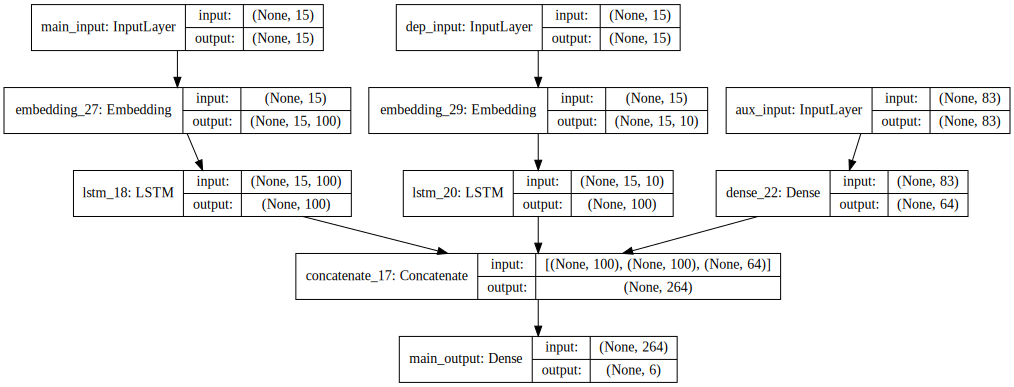

In [0]:
plot_model(model_lstm, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(model_lstm,show_shapes=True).create(prog='dot', format='svg'))
#print model_LSTM.summary()

In [0]:
kernel_stmt = []
kernel_pos = []
kernel_dep = []

use_pos=False
use_meta=True
use_dep=True

statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
x_stmt = Embedding(vocab_length+1,EMBED_DIM,weights=[embedding_matrix],input_length=num_steps,trainable=False)(statement_input) 

# pos embed LSTM
pos_input = Input(shape=(num_steps,), dtype='int32', name='pos_input')
x_pos = Embedding(max(pos_dict.values()), max(pos_dict.values()), weights=[pos_embeddings], input_length=num_steps, trainable=False)(pos_input)

# dep embed LSTM
dep_input = Input(shape=(num_steps,), dtype='int32', name='dep_input')
x_dep = Embedding(max(dep_dict.values()), max(dep_dict.values()), weights=[dep_embeddings], input_length=num_steps, trainable=False)(dep_input)


for kernel in kernel_sizes:
    x_1 = Conv1D(filters=filter_size,kernel_size=kernel)(x_stmt)
    x_1 = GlobalMaxPool1D()(x_1)
    kernel_stmt.append(x_1)
    
    x_2 = Conv1D(filters=filter_size,kernel_size=kernel)(x_pos)
    x_2 = GlobalMaxPool1D()(x_2)
    kernel_pos.append(x_2)
    
    x_3 = Conv1D(filters=filter_size,kernel_size=kernel)(x_dep)
    x_3 = GlobalMaxPool1D()(x_3)
    kernel_dep.append(x_3)
    
conv_in1 = keras.layers.concatenate(kernel_stmt)
#conv_in1 = conv_in1.add(Dropout(0.6))
conv_in1 = Dense(128, activation='relu')(conv_in1)

conv_in2 = keras.layers.concatenate(kernel_pos)
#conv_in2 = Dropout(0.6)(conv_in2)
conv_in2 = Dense(128, activation='relu')(conv_in2)

conv_in3 = keras.layers.concatenate(kernel_dep)
#conv_in3 = Dropout(0.6)(conv_in3)
conv_in3 = Dense(128, activation='relu')(conv_in3)

# meta data
meta_input = Input(shape=(X_train_meta.shape[1],), name='aux_input')
x_meta = Dense(64, activation='relu')(meta_input)

if use_pos and use_meta:
  if use_dep:
    x = keras.layers.concatenate([conv_in1, conv_in2, conv_in3, x_meta])
  else:
    x = keras.layers.concatenate([conv_in1, conv_in2, x_meta])
elif use_meta:
  if use_dep:
    x = keras.layers.concatenate([conv_in1, conv_in3, x_meta])
  else:
    x = keras.layers.concatenate([conv_in1, x_meta])
elif use_pos:
  if use_dep:
    x = keras.layers.concatenate([conv_in1, conv_in2, conv_in3])
  else:
    x = keras.layers.concatenate([conv_in1, conv_in2])
else:
  if use_dep:
    x = keras.layers.concatenate([conv_in1, conv_in3])
  else:
    x = conv_in1



main_output = Dense(6, activation='softmax', name='main_output')(x)

if use_pos and use_meta:
  if use_dep:
    model_cnn = Model(inputs=[statement_input, pos_input, dep_input, meta_input], outputs=[main_output])
  else:
    model_cnn = Model(inputs=[statement_input, pos_input, meta_input], outputs=[main_output])
elif use_meta:
  if use_dep:
    model_cnn = Model(inputs=[statement_input, dep_input, meta_input], outputs=[main_output])
  else:
    model_cnn = Model(inputs=[statement_input, meta_input], outputs=[main_output])
elif use_pos:
  if use_dep:
    model_cnn = Model(inputs=[statement_input, pos_input, dep_input], outputs=[main_output])
  else:
    model_cnn = Model(inputs=[statement_input, pos_input], outputs=[main_output])
else:
  if use_dep:
    model_cnn = Model(inputs=[statement_input, dep_input], outputs=[main_output])
  else:
    model_cnn = Model(inputs=[statement_input], outputs=[main_output])

In [0]:
#plot_model(model, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)
#SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
print model_cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 15)           0                                            
__________________________________________________________________________________________________
dep_input (InputLayer)          (None, 15)           0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 15, 100)      1240900     main_input[0][0]                 
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 15, 10)       100         dep_input[0][0]                  
__________________________________________________________________________________________________
conv1d_28 

In [0]:
train(model_cnn,'cnn', use_pos, use_meta, use_dep)

Train on 10240 samples, validate on 1284 samples
Epoch 1/10
10240/10240 [==============================] - 2s 235us/step - loss: 1.8096 - categorical_accuracy: 0.2061 - val_loss: 1.7986 - val_categorical_accuracy: 0.2079

Epoch 00001: val_categorical_accuracy improved from -inf to 0.20794, saving model to cnn_weights_best.hdf5
Epoch 2/10
10240/10240 [==============================] - 1s 60us/step - loss: 1.7111 - categorical_accuracy: 0.2575 - val_loss: 1.7233 - val_categorical_accuracy: 0.2095

Epoch 00002: val_categorical_accuracy improved from 0.20794 to 0.20950, saving model to cnn_weights_best.hdf5
Epoch 3/10
10240/10240 [==============================] - 1s 52us/step - loss: 1.6576 - categorical_accuracy: 0.3054 - val_loss: 1.7434 - val_categorical_accuracy: 0.2375

Epoch 00003: val_categorical_accuracy improved from 0.20950 to 0.23754, saving model to cnn_weights_best.hdf5
Epoch 4/10
10240/10240 [==============================] - 1s 51us/step - loss: 1.6104 - categorical_accurac

In [0]:
(fw, tb) = evaluate('cnn', use_pos, use_meta, use_dep)

1267/1267 [==============================] - 1s 673us/sample
True
Correctly Predicted :  294 / 1267
Accuracy :  23.204419889502763


In [0]:
print_best_false_true_predicted(fw, tb)

*****************************************************************
******************** False statements *************************
0.72934276
id             6045.json                                                                                                                                                             
label          pants-fire                                                                                                                                                            
statement      Says Hawaii Gov. Neil Abercrombie made a late-night visit to Kinkos to forge President Barack Obamas birth certificate two days before Obama unveiled it to the media.
subject        obama-birth-certificate                                                                                                                                               
speaker        chain-email                                                                                                         

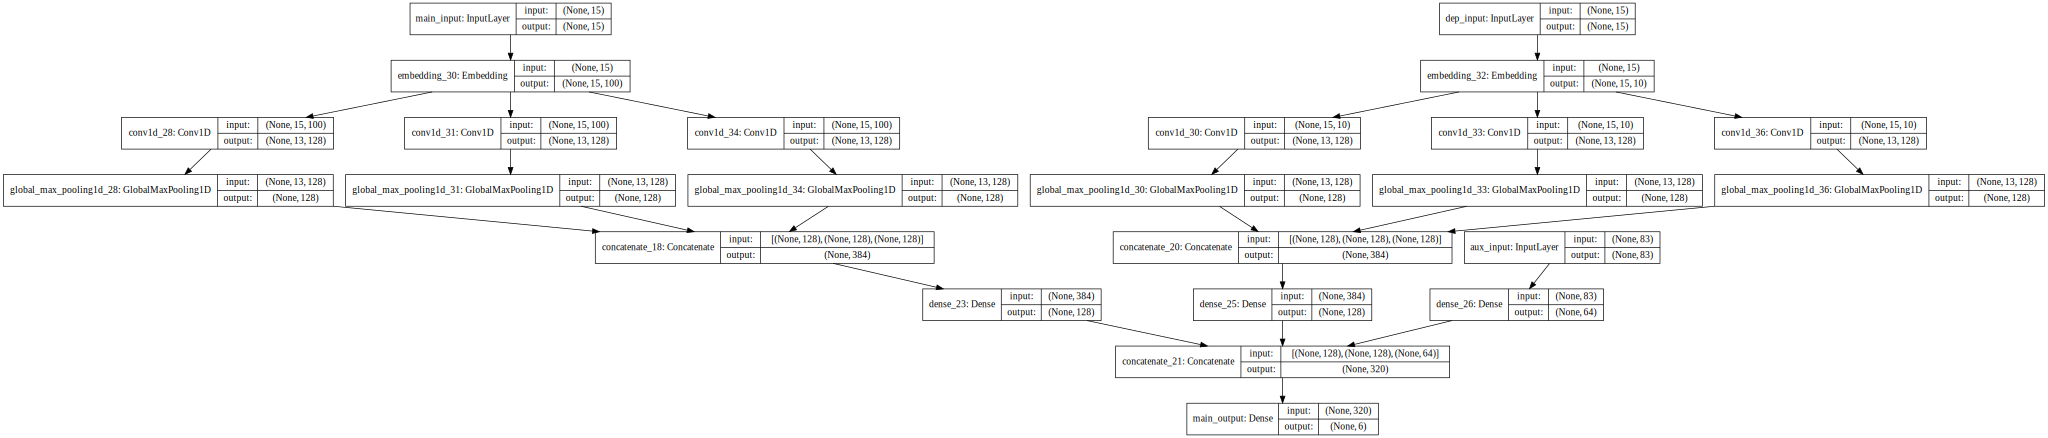

In [0]:
plot_model(model_cnn, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(model_cnn,show_shapes=True).create(prog='dot', format='svg'))
#print model_cnn.summary()